In [33]:
import sys
import tt
import numpy as np
sys.path.append('../../')

import brewer2mpl
import matplotlib as mpl
%matplotlib inline
import matplotlib.pylab as plt
from src.TTRegression import TTRegression
from sklearn import metrics
import utils
import cPickle as pickle
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datasets = utils.load_datasets(0.95)

Reading the datasets...
Car
dataset len: 1728

Original targets:
unacc    1210
acc       384
good       69
vgood      65
Name: target, dtype: int64
newHIV-1
dataset len: 1625

Original targets:
-1    1250
 1     375
Name: 1, dtype: int64
Chess
dataset len: 3196

Original targets:
won      1669
nowin    1527
Name: 36, dtype: int64
Prudential
('Dataset len: ', (59381, 1584))
car
(1642, 21)
prudential
(56412, 1584)
chess
(3037, 73)
hiv
(1544, 160)


# Learn

In [34]:
dataset_name = 'car'
X_train = datasets[dataset_name]['scaled_x_train']
y_train = datasets[dataset_name]['y_train']
X_val = datasets[dataset_name]['scaled_x_test']
y_val = datasets[dataset_name]['y_test']
plain_sgd = {}
riemannian_sgd = {}

for batch_size in [-1, 100, 500]:
    model = TTRegression('all-subsets', 'logistic', 4, 'sgd', max_iter=10000, verbose=1,
                         fit_intercept=False, batch_size=batch_size, reg=0.)
    model.fit_log_val(X_train, y_train, X_val, y_val)
    plain_sgd[batch_size] = model
    rieamannian_model = TTRegression('all-subsets', 'logistic', 4, 'riemannian-sgd', max_iter=800, verbose=1,
                                     batch_size=batch_size, fit_intercept=False, reg=0.)
    rieamannian_model.fit_log_val(X_train, y_train, X_val, y_val)
    riemannian_sgd[batch_size] = rieamannian_model


# Save

In [35]:
with open('riemannian_vs_plain.pickle', 'wb') as f:
    obj = {'plain_sgd': plain_sgd, 'riemannian_sgd': riemannian_sgd, 'X': X_train, 'y': y_train, 'val_X': X_val, 'val_y': y_val}
    pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Plot

In [162]:
params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [3, 2.5]
   }
mpl.rcParams.update(params)

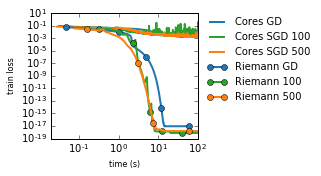

In [207]:
# bmap = brewer2mpl.get_map('Set2', 'qualitative', 3)
# colors = bmap.mpl_colors
tableau20 = [(31, 119, 180), (44, 160, 44), (255, 127, 14), (255, 187, 120)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)    
colors = tableau20
    
    
rounding = pickle.load(open('riemannian_vs_plain_with_val_rounding.pickle', 'rb'))
fig = plt.figure()
plt.loglog(rounding['plain_sgd'][-1].logger.time_hist,
           rounding['plain_sgd'][-1].logger.loss_hist['train']['logistic'], label='Cores GD',
           linewidth=2, color=colors[0])
plt.loglog(rounding['plain_sgd'][100].logger.time_hist, rounding['plain_sgd'][100].logger.loss_hist['train']['logistic'],
           label='Cores SGD 100', linewidth=2, color=colors[1])
plt.loglog(rounding['plain_sgd'][500].logger.time_hist, rounding['plain_sgd'][500].logger.loss_hist['train']['logistic'],
           label='Cores SGD 500', linewidth=2, color=colors[2])

grid = [0.01, 1, 5, 12, 60]
x = rounding['riemannian_sgd'][-1].logger.time_hist
marker_indices = np.searchsorted(x, grid)
plt.loglog(rounding['riemannian_sgd'][-1].logger.time_hist,
               rounding['riemannian_sgd'][-1].logger.loss_hist['train']['logistic'], marker='o', markevery=marker_indices, label='Riemann GD', linewidth=2, color=colors[0])
grid = [0.05, 2, 6, 12, 40]
# grid = np.logspace(-1.0, 1.7, num=6)
x = rounding['riemannian_sgd'][100].logger.time_hist
marker_indices = np.searchsorted(x, grid)
plt.loglog(rounding['riemannian_sgd'][100].logger.time_hist,
               rounding['riemannian_sgd'][100].logger.loss_hist['train']['logistic'], marker='o', markevery=marker_indices, label='Riemann 100', linewidth=2, color=colors[1])
# grid = np.logspace(-1.5, 1.6, num=6)
grid = [0.1, 3, 7.5, 60]
x = rounding['riemannian_sgd'][500].logger.time_hist
marker_indices = np.searchsorted(x, grid)
plt.loglog(rounding['riemannian_sgd'][500].logger.time_hist,
               rounding['riemannian_sgd'][500].logger.loss_hist['train']['logistic'], marker='o', markevery=marker_indices, label='Riemann 500', linewidth=2, color=colors[2])

legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1.04), frameon=False)
plt.xlabel('time (s)')
plt.ylabel('train loss')
plt.minorticks_off()
ax = plt.gca()
ax.set_xlim([0.02, 100])
fig.tight_layout()
# frame = legend.get_frame()

# frame.set_facecolor('0.9')
# frame.set_edgecolor('255')

In [208]:
fig.savefig('riemannian_vs_plain.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

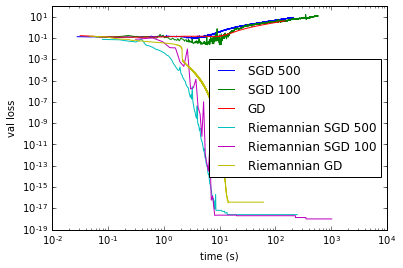

In [37]:
for batch_size in plain_sgd.keys():
    if batch_size == -1:
        name = 'GD'
    else:
        name = 'SGD ' + str(batch_size)
    plt.loglog(plain_sgd[batch_size].logger.time_hist, plain_sgd[batch_size].logger.loss_hist['valid']['logistic'], label=name)
for batch_size in plain_sgd.keys():
    if batch_size == -1:
        name = 'Riemannian GD'
    else:
        name = 'Riemannian SGD ' + str(batch_size)
    plt.loglog(riemannian_sgd[batch_size].logger.time_hist, riemannian_sgd[batch_size].logger.loss_hist['valid']['logistic'], label=name)
plt.legend(loc='best')
plt.xlabel('time (s)')
plt.ylabel('val loss')